In [2]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
titanic_df = pd.read_csv('train.csv')

In [68]:
def male_female_child(passenger):
    # 年齢と性別のデータを取得します。
    age,sex = passenger
    # 年齢を調べて16歳未満なら、子供。それ以外は性別をそのまま返します。
    if age < 16:
        return 3
    else:
        if sex == 'male':
            return 1
        else:
            return 2
    


In [99]:
def pre_process(titanic_df):
    # personという新しい列を追加します。
    #titanic_df['Person'] = titanic_df[['Age','Sex']].apply(male_female_child,axis=1)
    titanic_df['Sex'] = titanic_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    titanic_df['FamilySize'] = titanic_df.Parch + titanic_df.SibSp + 1
    
    titanic_df['Alone'] = 0
    titanic_df['Alone'].loc[titanic_df['FamilySize'] == 1] = 1
    titanic_df['Alone'].loc[titanic_df['FamilySize'] > 1 ] = 0
    
    titanic_df = titanic_df.fillna({'Embarked' : 'S'}) 
    titanic_df['Embarked'] = titanic_df['Embarked'].map( {'S': 1, 'C': 2, 'Q' : 3} )
    
    titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
    titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
    titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')
    titanic_df['Title'] = titanic_df['Title'].map( {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})

    titanic_df = titanic_df.fillna({'Fare' : titanic_df.Fare.mean()}) 
    titanic_df.loc[ titanic_df['Fare'] <= 7.91, 'Fare'] = 0
    titanic_df.loc[(titanic_df['Fare'] > 7.91) & (titanic_df['Fare'] <= 14.454), 'Fare'] = 1
    titanic_df.loc[(titanic_df['Fare'] > 14.454) & (titanic_df['Fare'] <= 31), 'Fare'] = 2
    titanic_df.loc[ titanic_df['Fare'] > 31, 'Fare'] = 3
    titanic_df['Fare'] = titanic_df['Fare'].astype(int)
    
    # Mapping Age
    titanic_df = titanic_df.fillna({'Age' : titanic_df.Age.mean()}) 
    titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
    titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
    titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
    titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
    titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

    return titanic_df

In [70]:
titanic_df = pre_process(titanic_df)

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [59]:
#from collections import Counter
#Counter(titanic_df.Embarked)

In [71]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Alone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,1.290685,0.523008,0.381594,1.505051,1.361392,1.904602,0.602694,1.728395
std,257.353842,0.486592,0.836071,0.477990,0.812620,1.102743,0.806057,1.118148,0.635673,1.613459,0.489615,1.030039
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.500000,1.000000,1.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,2.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,4.000000,8.000000,6.000000,3.000000,3.000000,11.000000,1.000000,5.000000


In [72]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,0,NaN,1,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,3,C85,2,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,1,NaN,1,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,3,C123,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,1,NaN,1,1,1,1


In [73]:
train_data = titanic_df.drop(['PassengerId','Name','SibSp','Parch', 'Ticket', 'Cabin'], 1)

In [74]:
train_data.describe()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Alone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,1.290685,1.505051,1.361392,1.904602,0.602694,1.728395
std,0.486592,0.836071,0.477990,0.812620,1.118148,0.635673,1.613459,0.489615,1.030039
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,1.000000,0.500000,1.000000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,4.000000,3.000000,3.000000,11.000000,1.000000,5.000000


In [75]:
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Alone,Title
0,0,3,1,1.0,0,1,2,0,1
1,1,1,0,2.0,3,2,2,0,3
2,1,3,0,1.0,1,1,1,1,2
3,1,1,0,2.0,3,1,2,0,3
4,0,3,1,2.0,1,1,1,1,1


In [76]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null float64
Fare          891 non-null int64
Embarked      891 non-null int64
FamilySize    891 non-null int64
Alone         891 non-null int64
Title         891 non-null int64
dtypes: float64(1), int64(8)
memory usage: 62.7 KB


In [162]:
#train_data = train_data[train_data.Person == 1]

In [77]:
t = train_data.iloc[:,0]
x = train_data.iloc[:,1:]

In [78]:
x = x.values

In [79]:
x = x.astype("f")
t = t.astype("i")

In [80]:
dataset = list(zip(x, t))

In [81]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainer
import cupy

from chainer import training
from chainer.training import extensions

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [82]:
n_train = int(len(dataset)*0.7)

In [83]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=1)

In [84]:
class NN(chainer.Chain):
    def __init__(self, n_mid_units1=3, n_out=2):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units1)
            self.fc2 = L.Linear(None, n_out)
            
            self.bn = L.BatchNormalization(8)
    
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [85]:
np.random.seed(1)
nn = NN()
model = L.Classifier(nn)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
batch_size = 10

In [86]:
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

In [87]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [88]:
epoch = 200

In [89]:
trainer = training.Trainer(updater, (epoch, "epoch"), out="result/titanic")

trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(trigger=(1, "epoch")))
trainer.extend(extensions.PrintReport(["epoch", "main/accuracy", "validation/main/accuracy", "main/loss", "validation/main/loss"]))

In [90]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss
1           0.568254       0.615741                  0.743348    0.708283              
2           0.646774       0.637963                  0.687969    0.643819              
3           0.679032       0.689815                  0.64776     0.602421              
4           0.738095       0.741667                  0.591825    0.5654                
5           0.76129        0.778704                  0.572261    0.541489              
6           0.785484       0.778704                  0.539165    0.520845              
7           0.784127       0.789815                  0.512349    0.500397              
8           0.783871       0.793519                  0.527435    0.491326              
9           0.790323       0.793519                  0.515839    0.482373              
10          0.798387       0.793519                  0.504042    0.477044              
11          0.788889       0.79351

91          0.806349       0.834259                  0.442909    0.420892              
92          0.796774       0.830556                  0.452229    0.425966              
93          0.803226       0.841667                  0.443805    0.420757              
94          0.798413       0.837963                  0.439286    0.422874              
95          0.806452       0.830556                  0.434223    0.423572              
96          0.796774       0.837963                  0.439901    0.422194              
97          0.8            0.837963                  0.452626    0.424163              
98          0.801613       0.823148                  0.437853    0.428251              
99          0.795161       0.84537                   0.435214    0.41877               
100         0.803226       0.837963                  0.436577    0.421781              
101         0.811111       0.830556                  0.449867    0.421826              
102         0.809677       0.830

182         0.791935       0.837963                  0.441547    0.423644              
183         0.801613       0.834259                  0.444482    0.431799              
184         0.803175       0.808333                  0.448855    0.446822              
185         0.791935       0.834259                  0.438202    0.423882              
186         0.801613       0.826852                  0.465523    0.429591              
187         0.793651       0.830556                  0.434232    0.428677              
188         0.814516       0.834259                  0.434092    0.431282              
189         0.808065       0.830556                  0.449562    0.432569              
190         0.809677       0.830556                  0.438475    0.430248              
191         0.803175       0.819444                  0.449205    0.438887              
192         0.804839       0.826852                  0.425444    0.431518              
193         0.81129        0.837

In [91]:
import json

In [92]:
with open("result/titanic/log") as f:
    logs = json.load(f)

In [93]:
results = pd.DataFrame(logs)

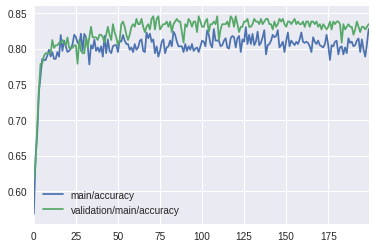

In [94]:
%matplotlib inline
results[["main/accuracy", "validation/main/accuracy"]].plot()

In [95]:
chainer.serializers.save_npz("models/titanic_5.npz", model)

In [190]:
model_man = L.Classifier(NN())
chainer.serializers.load_npz("models/titanic_man_3.npz", model_man)

In [191]:
model = L.Classifier(NN())
chainer.serializers.load_npz("models/titanic_4.npz", model)

In [100]:
titanic_df = pd.read_csv('test.csv')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [101]:
titanic_df = pre_process(titanic_df)

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [102]:
test_data = titanic_df.drop(['PassengerId','Name','SibSp','Parch', 'Ticket', 'Cabin'], 1)

In [103]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass        418 non-null int64
Sex           418 non-null int64
Age           418 non-null float64
Fare          418 non-null int64
Embarked      418 non-null int64
FamilySize    418 non-null int64
Alone         418 non-null int64
Title         418 non-null int64
dtypes: float64(1), int64(7)
memory usage: 26.2 KB


In [104]:
x = test_data.values

In [105]:
x = x.astype("f")

In [106]:
survived = []

In [107]:
test_data.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Alone,Title
0,3,1,2.0,0,3,1,1,1
1,3,0,2.0,0,1,2,0,3
2,2,1,3.0,1,3,1,1,1
3,3,1,1.0,1,1,1,1,1
4,3,0,1.0,1,1,3,0,3


In [108]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    for i, x_ in enumerate(x):
        x_new = x_
        x_new = x_new[np.newaxis]
        '''
        if test_data['Person'].iloc[i] == 1:
            y = model_man.predictor(x_new)
        else:
             y = model.predictor(x_new)
        '''
        y = model.predictor(x_new)
        y = F.softmax(y)
        survived.append(np.argmax(y.array))

In [109]:
len(survived)

418

In [110]:
titanic_df['Survived'] = np.array(survived)

In [112]:
predict_df = titanic_df.drop(['Name','Title' ,'Sex','SibSp','Parch','FamilySize' ,'Fare', 'Ticket', 'Cabin', 'Embarked', 'Pclass', 'Age', 'Alone'], 1)

In [113]:
predict_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [114]:
predict_df.to_csv('predict_20181128.csv')